# Boosting to Uniformity

In physics applications frequently we need to achieve uniformity of predictions along some features.
For instance, when testing for the existence of a new particle, we need a classifier to be uniform in background along the mass (otherwise one can get false discovery due to so-called peaking background).

This notebook contains some comparison of classifiers. The target is to obtain flat effiency in __signal__ (without significally loosing quality of classification) in Dalitz features.

The classifiers compared are 

* plain __GradientBoosting__ 
* __uBoost__
* gradient boosting with knn-Ada loss (__UGB+knnAda__) 
* gradient boosting with FlatnessLoss (__UGB+FlatnessLoss__)

We use dataset from paper about `uBoost` for demonstration purposes.
We have a plenty of data here, so results are quite stable

In [1]:
# downloading data
!wget -O ../data/dalitzdata.root -nc https://github.com/arogozhnikov/hep_ml/blob/data/data_to_download/dalitzdata.root?raw=true

File ‘../data/dalitzdata.root’ already there; not retrieving.


In [2]:
# we are installing rep for nice plots and reports here
!pip install rep --no-dependencies

In [3]:
import pandas, numpy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# this wrapper makes it possible to train on subset of features
from rep.estimators import SklearnClassifier
from matplotlib import pyplot as plt
from hep_ml.commonutils import train_test_split
from hep_ml import uboost, gradientboosting as ugb, losses

/home/axelr/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Loading data

In [4]:
import root_numpy
used_columns = ["Y1", "Y2", "Y3", "M2AB", "M2AC"]
data = pandas.DataFrame(root_numpy.root2array('../data/dalitzdata.root', treename='tree'))
labels = data['labels']
data = data.drop('labels', axis=1)

Welcome to JupyROOT 6.14/04


## Distributions in the Dalitz features for signal and background
As we can see, the background is distributed mostly in the corners of Dalitz plot, <br />
and for traditional classifiers this results in poor effieciency of signal in the corners.

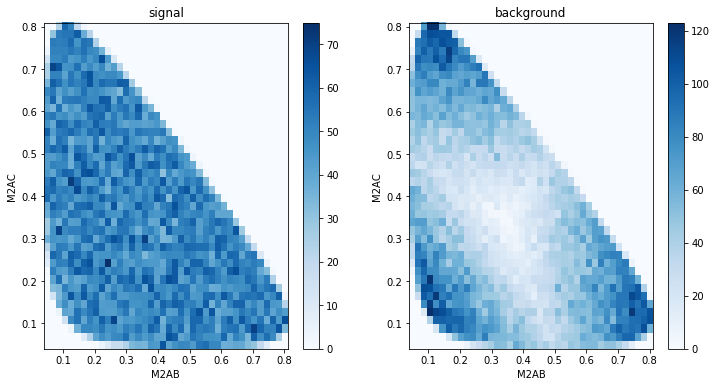

In [5]:
def plot_distribution(data_frame, var_name1='M2AB', var_name2='M2AC', bins=40):
    """The function to plot 2D distribution histograms"""
    plt.hist2d(data_frame[var_name1], data_frame[var_name2], bins = 40, cmap=plt.cm.Blues)
    plt.xlabel(var_name1)
    plt.ylabel(var_name2)
    plt.colorbar()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.title("signal"),       plot_distribution(data[labels==1])
plt.subplot(1, 2, 2), plt.title("background"),   plot_distribution(data[labels==0])
pass

## Preparation of train/test datasets

In [6]:
trainX, testX, trainY, testY = train_test_split(data, labels, random_state=42)

## Setting up classifiers, training

In [7]:
uniform_features  = ["M2AB", "M2AC"]
train_features = ["Y1", "Y2", "Y3"]
n_estimators = 150
base_estimator = DecisionTreeClassifier(max_depth=4)

__uBoost__ training takes much time, so we reduce number of efficiency_steps, use prediction smoothing and run uBoost in threads

In [8]:
from rep.metaml import ClassifiersFactory

classifiers = ClassifiersFactory()

base_ada = GradientBoostingClassifier(max_depth=4, n_estimators=n_estimators, learning_rate=0.1)
classifiers['AdaBoost'] = SklearnClassifier(base_ada, features=train_features)


knnloss = ugb.KnnAdaLossFunction(uniform_features, knn=10, uniform_label=1)
ugbKnn = ugb.UGradientBoostingClassifier(loss=knnloss, max_depth=4, n_estimators=n_estimators,
                                        learning_rate=0.4, train_features=train_features)
classifiers['uGB+knnAda'] = SklearnClassifier(ugbKnn) 

uboost_clf = uboost.uBoostClassifier(uniform_features=uniform_features, uniform_label=1,
                                     base_estimator=base_estimator, 
                                     n_estimators=n_estimators, train_features=train_features, 
                                     efficiency_steps=12, n_threads=4)
classifiers['uBoost'] = SklearnClassifier(uboost_clf)

flatnessloss = ugb.KnnFlatnessLossFunction(uniform_features, fl_coefficient=3., power=1.3, uniform_label=1)
ugbFL = ugb.UGradientBoostingClassifier(loss=flatnessloss, max_depth=4, 
                                       n_estimators=n_estimators, 
                                       learning_rate=0.1, train_features=train_features)
classifiers['uGB+FL'] = SklearnClassifier(ugbFL)


classifiers.fit(trainX, trainY, parallel_profile='threads-4')
pass

/home/axelr/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


model AdaBoost     was trained in 20.19 seconds
model uGB+knnAda   was trained in 41.52 seconds
model uBoost       was trained in 156.06 seconds
model uGB+FL       was trained in 162.18 seconds
Totally spent 162.18 seconds on training


## Let's look at the results of training

dependence of classification quality on the number of trees built (ROC AUC - an area under the ROC curve, the more the better)

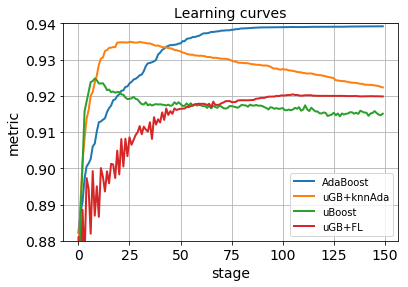

In [9]:
from rep.report.metrics import RocAuc
report = classifiers.test_on(testX, testY)

plt.ylim(0.88, 0.94)
report.learning_curve(RocAuc(), steps=1)

## SDE (squared deviation of efficiency) learning curve
SDE vs the number of built trees. SDE is a metric of nonuniformity &mdash; less is better. 

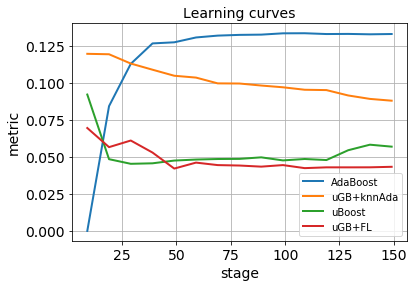

In [10]:
from hep_ml.metrics import BinBasedSDE, KnnBasedCvM
report.learning_curve(BinBasedSDE(uniform_features, uniform_label=1))

## CvM learning curve
CvM is a metric of non-uniformity based on Cramer-von Mises distance. We are using knn (based on neighbours) version here.

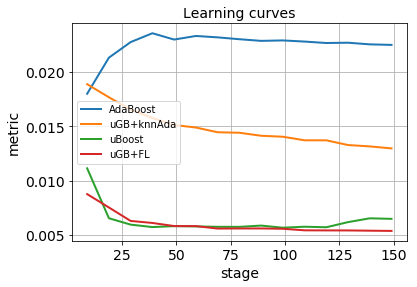

In [11]:
report.learning_curve(KnnBasedCvM(uniform_features, uniform_label=1))

# ROC curves after training

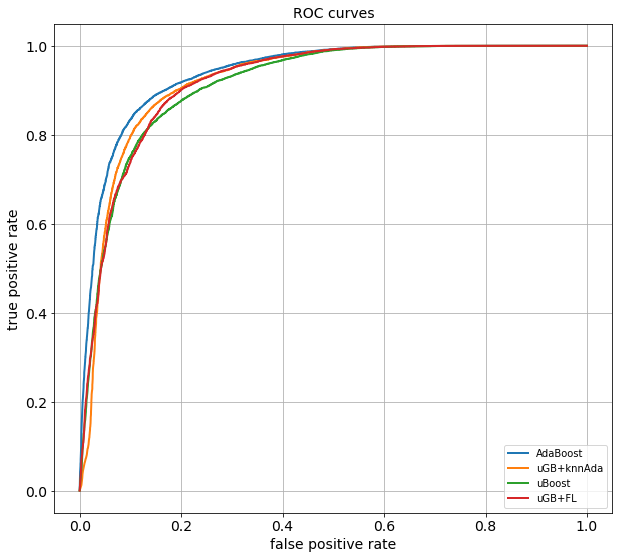

In [12]:
report.roc().plot(new_plot=True, figsize=[10, 9])

## Signal efficiency 
global cut corresponds to an average signal efficiency=0.5. In ideal case the picture shall be white.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


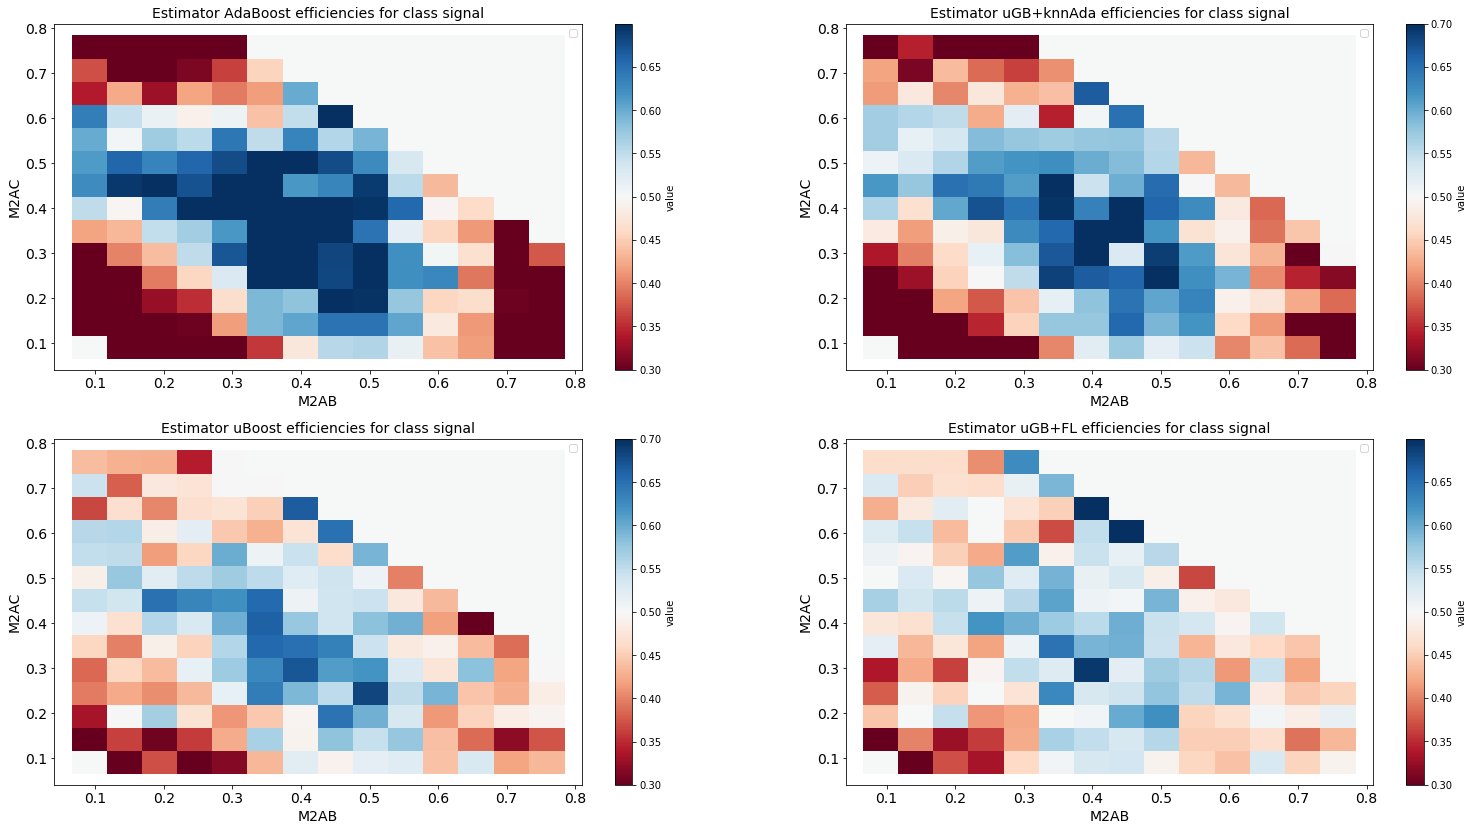

In [13]:
report.efficiencies_2d(uniform_features, efficiency=0.5, signal_label=1, n_bins=15, 
                       labels_dict={1: 'signal'})

the same for global efficiency = 0.7

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


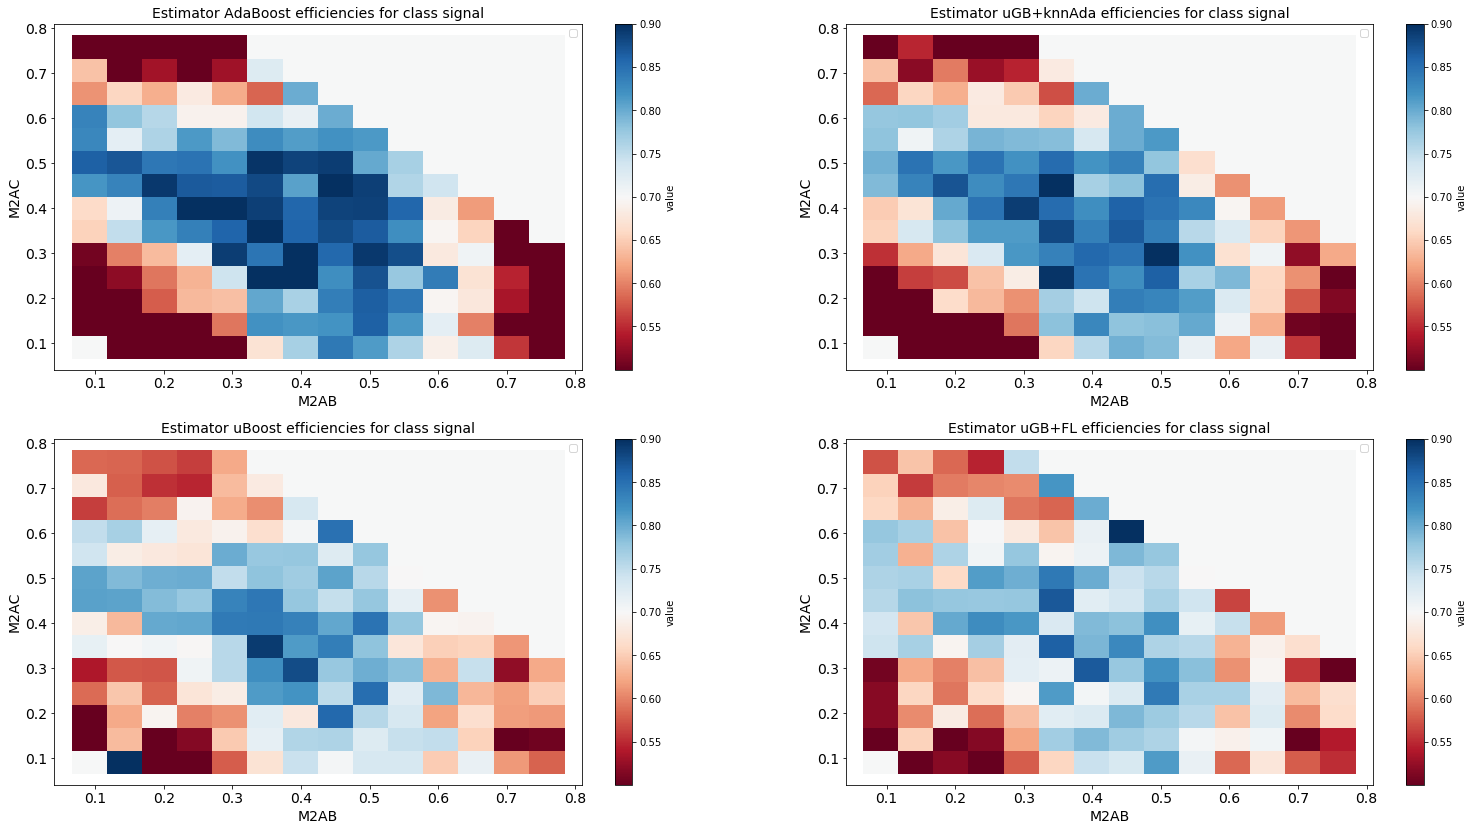

In [14]:
report.efficiencies_2d(uniform_features, efficiency=0.7, signal_label=1, n_bins=15, 
                       labels_dict={1: 'signal'})